# Introduction

**Nama Tim**: Plingo

**Asal Kampus**: Bina Nusantara University

**Objective**:  
Melakukan eksplorasi dan segmentasi terhadap data video TikTok guna memahami pola-pola konten viral dan trending berdasarkan karakteristik video, waktu unggah, engagement, dan deskripsi. Tahap eksplorasi bertujuan menggali insight awal dari distribusi dan hubungan antar fitur, sedangkan tahap modeling menggunakan pendekatan unsupervised learning (clustering) seperti K-Means, DBSCAN, dan HDBSCAN untuk mengelompokkan konten ke dalam segmen-segmen homogen. Hasil segmentasi ini diharapkan dapat membantu brand, kreator, atau analis media sosial dalam memahami struktur konten viral dan menyusun strategi berbasis data.


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import hdbscan
import glob
import re

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
# Ambil data hasil scraping dari folder `data`
main_data = glob.glob("data/*.csv")

In [3]:
# Gabungkan data yang sudah discraping
df_list = [pd.read_csv(file) for file in main_data]
merged_df = pd.concat(df_list, ignore_index=True)

In [4]:
# Simpan data gabungan ke file CSV
merged_df.to_csv("merged_raw_data.csv", index=False)

In [5]:
# Copy merged data sebelum cleaning
df = merged_df.copy()

# Data Cleaning

In [6]:
# Cek jumlah baris sebelum cleaning
print("Jumlah baris sebelum cleaning:", len(df))

Jumlah baris sebelum cleaning: 2731


In [7]:
# Cek format data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   2728 non-null   object
 1   Video Description    2731 non-null   object
 2   Video Create Time    2731 non-null   object
 3   Video Category Type  2731 non-null   object
 4   Video Duration       2731 non-null   object
 5   Video Width          2731 non-null   object
 6   Video Height         2731 non-null   object
 7   Video URL            2731 non-null   object
 8   Video Cover          2731 non-null   object
 9   Video View Count     2731 non-null   object
 10  Video Like Count     2731 non-null   object
 11  Video Comment Count  2731 non-null   object
 12  Video Share Count    2731 non-null   object
 13  Author ID            2731 non-null   object
 14  Author Nickname      2731 non-null   object
 15  Author Username      2731 non-null   object
 16  Author

In [8]:
# Mengubah format kolom "Video Create Time" menjadi datetime
df["Video Create Time"] = pd.to_datetime(df["Video Create Time"], unit="s", errors="coerce")

In [9]:
# Drop kolom yang tidak diperlukan
columns_to_drop = [
    "Video Width", "Video Height", "Video URL", "Video Cover",
    "Author ID", "Author Avatar", "Music ID", "Music Cover", "Music Duration","Music URL"
]

df.drop(columns=columns_to_drop, inplace=True)

In [10]:
# Cek apakah ada data yang duplikat
df['id'].duplicated().any()

True

In [11]:
# Cek total data yang duplikat
df["id"].duplicated().sum()


111

In [12]:
# Drop kolom duplikat
df.drop_duplicates(subset="id", keep="first", inplace=True)

In [13]:
# Crosscheck data duplikat
df['id'].duplicated().any()

False

In [14]:
# Mengganti format kolom numerik
numeric_cols = [
    "Video View Count", "Video Like Count",
    "Video Comment Count", "Video Share Count",
    "Video Duration"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [15]:
# Bersihkan emoji
def bersihkan_karakter_aneh(text):
    if pd.isna(text):
        return text
    return re.sub(r'[^\x00-\x7F]+', '', str(text))

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(bersihkan_karakter_aneh)


In [16]:
# Drop video iklan
df = df[df["Author Verified"] != "Not Available"]

In [17]:
# Cek jumlah indeks yang hilang
df.isna().sum().sort_values(ascending=False)

id                     0
Video Description      0
Video Create Time      0
Video Category Type    0
Video Duration         0
Video View Count       0
Video Like Count       0
Video Comment Count    0
Video Share Count      0
Author Nickname        0
Author Username        0
Author Bio             0
Author Verified        0
Music Title            0
Music Author           0
Video Page URL         0
dtype: int64

In [18]:
# Menghapus trailing space
for col in df.select_dtypes(include='object').columns:
    df.loc[:, col] = df[col].str.strip()

In [19]:
# Ganti string kosong jadi NaN (biar fillna bisa kerja)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Isi nilai kosong
df["Video Description"].fillna("missing_description", inplace=True)
df["Author Nickname"].fillna(df["Author Username"], inplace=True)
df["Author Bio"].fillna("No bio yet", inplace=True)
df["Music Title"].fillna("unknown", inplace=True)
df["Music Author"].fillna("unknown", inplace=True)

# Ganti string literal "Not Available" ke placeholder/value default
df.loc[:, "Video Description"] = df["Video Description"].replace("Not Available", "missing_description")
df.loc[:, "Video Category Type"] = df["Video Category Type"].replace("Not Available", "unknown")

In [20]:
# Memperbaiki format string ke lowercase dan menghapus trailing space
exclude_cols = ["Video Page URL"]

for col in df.select_dtypes(include='object').columns:
    if col not in exclude_cols:
        df.loc[:, col] = df[col].str.strip().str.lower()


In [21]:
# Ganti string "not available" ke placeholder/value default
df["Music Author"] = df["Music Author"].replace("not available", "unknown")
df["Music Title"] = df["Music Title"].replace("not available", "unknown")

In [22]:
# Tambahkan kolom baru
df["Upload Hour"] = df["Video Create Time"].dt.hour
df["Upload Day"] = df["Video Create Time"].dt.day_name()


In [23]:
# Mengubah tipe data kolom kategorikal menjadi tipe data kategori 
df["Author Verified"] = df["Author Verified"].astype("category")
df["Video Category Type"] = df["Video Category Type"].astype("category")
df["Upload Day"] = df["Upload Day"].astype("category")


In [24]:
# Drop kolom `id`
df.drop(columns=["id"], inplace=True)


In [25]:
# Reindexing kolom
df = df[[
    "Video Page URL", "Video Create Time", "Video Category Type",
    "Upload Hour", "Upload Day", "Video Duration",
    "Video View Count", "Video Like Count", "Video Comment Count", "Video Share Count",
    "Author Username", "Author Nickname", "Author Bio", "Author Verified",
    "Video Description", "Music Title", "Music Author"
]]

In [26]:
# Ganti ke tipe bool
df["Author Verified"] = df["Author Verified"].map({"yes": True, "no": False})

In [27]:
# Cek jumlah baris setelah cleaning
print("Jumlah baris setelah cleaning:", len(df))

Jumlah baris setelah cleaning: 2600


In [28]:
# Save cleaned data
df.to_csv("cleaned_data.csv", index=False)

# Preprocessing

| Feature               | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| Video Page URL        | URL halaman video di TikTok.                                                |
| Video Create Time     | Waktu video dibuat dan diunggah.                                            |
| Video Category Type   | Kode kategori video berdasarkan klasifikasi TikTok.                         |
| Upload Hour           | Jam ketika video diunggah (0-23).                                           |
| Upload Day            | Hari dalam seminggu ketika video diunggah.                                  |
| Video Duration        | Durasi video dalam detik.                                                   |
| Video View Count      | Jumlah penayangan video.                                                    |
| Video Like Count      | Jumlah like yang diberikan ke video.                                        |
| Video Comment Count   | Jumlah komentar yang diterima video.                                        |
| Video Share Count     | Jumlah share yang dilakukan oleh pengguna.                                  |
| Author Username       | Username akun pembuat video.                                                |
| Author Nickname       | Nama tampilan akun pembuat video.                                           |
| Author Bio            | Deskripsi atau bio penulis akun.                                            |
| Author Verified       | Status verifikasi akun (True/False).                                        |
| Video Description     | Deskripsi atau caption video.                                               |
| Music Title           | Judul musik yang digunakan pada video.                                      |
| Music Author          | Nama pembuat atau pemilik musik.                                            |


In [29]:
# Make new dataset
df = pd.read_csv('cleaned_data.csv')
# Show first 10 data
df.head(10)

,Video Page URL,Video Create Time,Video Category Type,Upload Hour,Upload Day,Video Duration,Video View Count,Video Like Count,Video Comment Count,Video Share Count,Author Username,Author Nickname,Author Bio,Author Verified,Video Description,Music Title,Music Author
0,https://www.tiktok.com/@redbullgermany/video/7...,2025-06-29 15:11:53,112,15,Sunday,55.0,308900000.0,11000000.0,89400.0,1500000.0,redbullgermany,red bull germany,"sei kein npc, klick auf folgen!",True,trockene klamotten - overrated #redbull #verl...,originalton,red bull germany
1,https://www.tiktok.com/@herexnyeni123/video/75...,2025-06-27 12:54:11,115,12,Friday,7.0,31500000.0,2300000.0,28400.0,1000000.0,herexnyeni123,std,follow tak folbek,False,melu trend,suara asli - std,std
2,https://www.tiktok.com/@adamalhidayat/video/75...,2025-07-03 06:59:33,120,6,Thursday,102.0,87600000.0,2100000.0,10200.0,24100.0,adamalhidayat,adamalhdyt,22 tahun\nyoutube : adam hidayat (10jt subscri...,False,kerjasama yg sangat baik#sipdam,woah (feat. d3mstreet),unknown
3,https://www.tiktok.com/@akuanhylupk/video/7522...,2025-07-01 08:37:18,106,8,Tuesday,16.0,39700000.0,6200000.0,100000.0,330700.0,akuanhylupk,nadiashayla,aku dan bapak tidak akan pernah menerima donas...,False,dirayakan kecil-kecilan oleh bapakku kata bap...,semua aku dirayakan,unknown
4,https://www.tiktok.com/@movietop23/video/75201...,2025-06-29 05:00:00,105,5,Sunday,23.0,76200000.0,7100000.0,45600.0,911300.0,movietop23,real farmer,i am a farmer and i love farming!,False,missing_description,original sound - real farmer,real farmer
5,https://www.tiktok.com/@gugun.gunawan_28/video...,2025-06-28 05:54:55,120,5,Saturday,14.0,31500000.0,1500000.0,34200.0,384700.0,gugun.gunawan_28,gugun gunawan,endors > dm\nsketsa sunda\n video ngakak\nfb,False,ongkekna kapaksa #ngakak #fyp,suara asli - gugun gunawan,gugun gunawan
6,https://www.tiktok.com/@haleyley_17/video/7514...,2025-06-10 15:37:21,104,15,Tuesday,8.0,28700000.0,3000000.0,8967.0,948000.0,haleyley_17,haley,heart nyo rin iba kong vid,False,#fyp #fypage,jet2 advert,a7-bbh | man
7,https://www.tiktok.com/@najir_tajir2/video/750...,2025-05-19 01:08:09,105,1,Monday,26.0,8300000.0,81700.0,1688.0,3710.0,najir_tajir2,najir tajir2,follow sosial media yang lain gays!\nig : naji...,False,keren! #fyppppppppppppppppppppppp,suara asli - najir tajir2,najir tajir2
8,https://www.tiktok.com/@t.septiawan/video/7501...,2025-05-07 10:18:08,104,10,Wednesday,17.0,2100000.0,67800.0,83.0,1528.0,t.septiawan,t.septiawan,@ \nkonten hiburan\nkonten pasutri\n business ...,False,seketika bingung #pareja #parejas #relatable #...,suara asli - t.septiawan,t.septiawan
9,https://www.tiktok.com/@dr.brandonkent/video/7...,2025-05-26 17:08:21,100,17,Monday,51.0,10500000.0,192500.0,403.0,3742.0,dr.brandonkent,brandonkentsky,not available,False,siapakah pria itu?#dokterbrando #prabowo #mpl ...,suara asli - dr brandonkent,brandonkentsky


In [30]:
# Show last 10 data
df.tail(10)

,Video Page URL,Video Create Time,Video Category Type,Upload Hour,Upload Day,Video Duration,Video View Count,Video Like Count,Video Comment Count,Video Share Count,Author Username,Author Nickname,Author Bio,Author Verified,Video Description,Music Title,Music Author
2590,https://www.tiktok.com/@explore.china6/video/7...,2025-07-05 13:26:16,105,13,Saturday,295.0,36900.0,4264.0,21.0,85.0,explore.china6,explore china,thanks,False,#handwork #chineseculture #learnontiktok,original sound,explore china
2591,https://www.tiktok.com/@mr_rndm1/video/7505019...,2025-05-16 12:29:59,104,12,Friday,8.0,8700000.0,776400.0,5724.0,102200.0,mr_rndm1,mr,gok gok gok gok,False,dari: @arraz140 #floptok #floptropica #flopto...,suara asli - pooqie,pooqie
2592,https://www.tiktok.com/@serlykas/video/7520128...,2025-06-26 05:38:34,119,5,Thursday,15.0,16300000.0,1600000.0,24600.0,91400.0,serlykas,serlykastariudin,ig: serlyfantasy23\nnugroho,False,"i mean, i mean ya robbal alamin #fyp #untukmu ...",original sound - gitaris toba,gitaris toba
2593,https://www.tiktok.com/@rynwar_/video/74930887...,2025-04-14 08:51:30,104,8,Monday,62.0,9800000.0,358100.0,8872.0,87000.0,rynwar_,ryn,bussines dm\ninstagram : @rynwar_,False,kami ga tau harus apa teh! #pov #relate #ngakak,suara asli - ryn,ryn
2594,https://www.tiktok.com/@ombusku_/video/7496023...,2025-04-22 06:40:40,111,6,Tuesday,15.0,26600000.0,332100.0,4921.0,18700.0,ombusku_,ombus kuliner,kuliner | ide bisnis | street food\ndm for bus...,False,membalas @chiiaww biasanya sih gitu #pisanggo...,busu setia (buset) - remastered 2023,silet open up & kaka andii
2595,https://www.tiktok.com/@ccaall.9/video/7518979...,2025-06-23 03:20:24,unknown,3,Monday,40.0,4300000.0,115200.0,3327.0,5782.0,ccaall.9,kuyang gentayangan,"hidup dengan impian besar\nmenciptakan momen, ...",False,gimana tanggapan kalian? #israel #tecnologia #...,suara asli - kuyang gentayangan,kuyang gentayangan
2596,https://www.tiktok.com/@nrh.nurhfzh/video/7519...,2025-06-25 14:02:52,106,14,Wednesday,19.0,1700000.0,46500.0,226.0,17100.0,nrh.nurhfzh,@nurhfzh_,hi!\nlike dan follow sebanyak-banyak nya\nteri...,False,bocil susah untuk di tebak #fypppppppppppppppp...,tunggu apa lagi,nyoman paul
2597,https://www.tiktok.com/@syfkmlh/video/75019803...,2025-05-08 07:55:13,106,7,Thursday,21.0,11700000.0,908100.0,2910.0,37400.0,syfkmlh,syafa,not available,False,#fyp #graduation makasi abah ummi dan yg lainnya,suara asli - syafa,syafa
2598,https://www.tiktok.com/@xxx.bellerich/video/75...,2025-06-02 12:34:56,107,12,Monday,20.0,3800000.0,96500.0,260.0,1952.0,xxx.bellerich,bloody mary,no bio yet,False,missing_description,suara asli - zen5embe,zen5embe
2599,https://www.tiktok.com/@cicichania96/video/749...,2025-04-29 10:43:33,113,10,Tuesday,14.0,18300000.0,933900.0,9798.0,124400.0,cicichania96,pororo shop,store pororo official,False,"beli hijab poby ya, beli di aku@pujii hijab heheh",suara asli - nabilaa,nabilaa


In [31]:
# Duplicate Dataset
new_data = df.copy()

In [32]:
# Show dataset info
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Video Page URL       2600 non-null   object 
 1   Video Create Time    2600 non-null   object 
 2   Video Category Type  2600 non-null   object 
 3   Upload Hour          2600 non-null   int64  
 4   Upload Day           2600 non-null   object 
 5   Video Duration       2600 non-null   float64
 6   Video View Count     2600 non-null   float64
 7   Video Like Count     2600 non-null   float64
 8   Video Comment Count  2600 non-null   float64
 9   Video Share Count    2600 non-null   float64
 10  Author Username      2600 non-null   object 
 11  Author Nickname      2600 non-null   object 
 12  Author Bio           2600 non-null   object 
 13  Author Verified      2600 non-null   bool   
 14  Video Description    2600 non-null   object 
 15  Music Title          2600 non-null   o

# EDA

In [33]:
# Describe dataset
new_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Upload Hour,2600.0,9.605769e+00,5.317431e+00,0.0,5.00,10.0,13.00,23.0
Video Duration,2600.0,4.711577e+01,9.104606e+01,0.0,10.00,17.0,52.00,1596.0
Video View Count,2600.0,1.200947e+07,2.920603e+07,2.0,1500000.00,4400000.0,11000000.00,731500000.0
Video Like Count,2600.0,6.405242e+05,1.651581e+06,1.0,65950.00,209450.0,581825.00,48000000.0
Video Comment Count,2600.0,4.934686e+03,1.249933e+04,0.0,424.00,1361.0,4288.25,245100.0
Video Share Count,2600.0,7.939065e+04,3.986161e+05,0.0,2334.75,9463.0,38075.00,8700000.0


- Semua metrik **sangat skewed** (distribusi tidak normal), artinya kita perlu pertimbangkan:
  - **Log transform / scaling** sebelum melakukan clustering atau model prediktif.


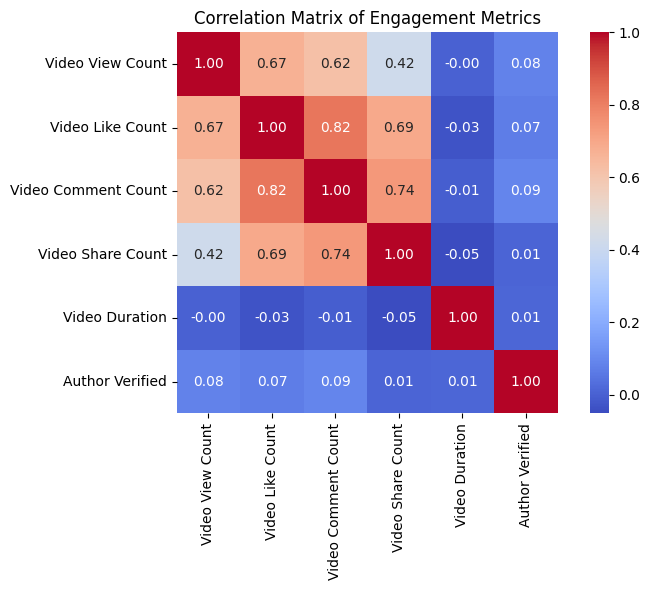

In [34]:
# Hitung korelasi antar fitur engagement
engagement_df = df[[
    "Video View Count",
    "Video Like Count",
    "Video Comment Count",
    "Video Share Count",
    "Video Duration",
    "Author Verified",
]]

correlation_matrix = engagement_df.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Engagement Metrics")
plt.tight_layout()
plt.show()


### Insight Korelasi

| Pasangan Variabel                | Korelasi | Insight                                                                 |
|----------------------------------|----------|-------------------------------------------------------------------------|
| View Count ↔ Like Count          | 0.67     | Korelasi kuat → video populer sering juga disukai.                     |
| Like Count ↔ Comment Count       | 0.82     | Korelasi sangat kuat → disukai = dikomentari → sinyal interaksi aktif.|
| Comment Count ↔ Share Count      | 0.74     | Korelasi tinggi → video yang banyak dikomentari juga cenderung dishare.|
| View Count ↔ Share Count         | 0.42     | Korelasi moderat → view tidak selalu berarti ingin share.             |
| Video Duration ↔ Engagement      | ≈ -0.05  | Korelasi sangat lemah/negatif → durasi **tidak memengaruhi** engagement.|
| Author Verified ↔ Engagement     | 0.01–0.09| Korelasi sangat kecil → status verified **tidak menjamin performa tinggi.**|

---

### Interpretasi

- **Durasi video** hampir tidak punya korelasi dengan view, like, comment, atau share.
  - Bisa disimpulkan bahwa **panjang video bukan faktor utama** dalam performa viral.
- **Author Verified** hanya memberi dampak kecil pada engagement:
  - Artinya, akun non-verified tetap punya potensi besar untuk viral.
  - Penting untuk fokus pada konten, bukan status akun.


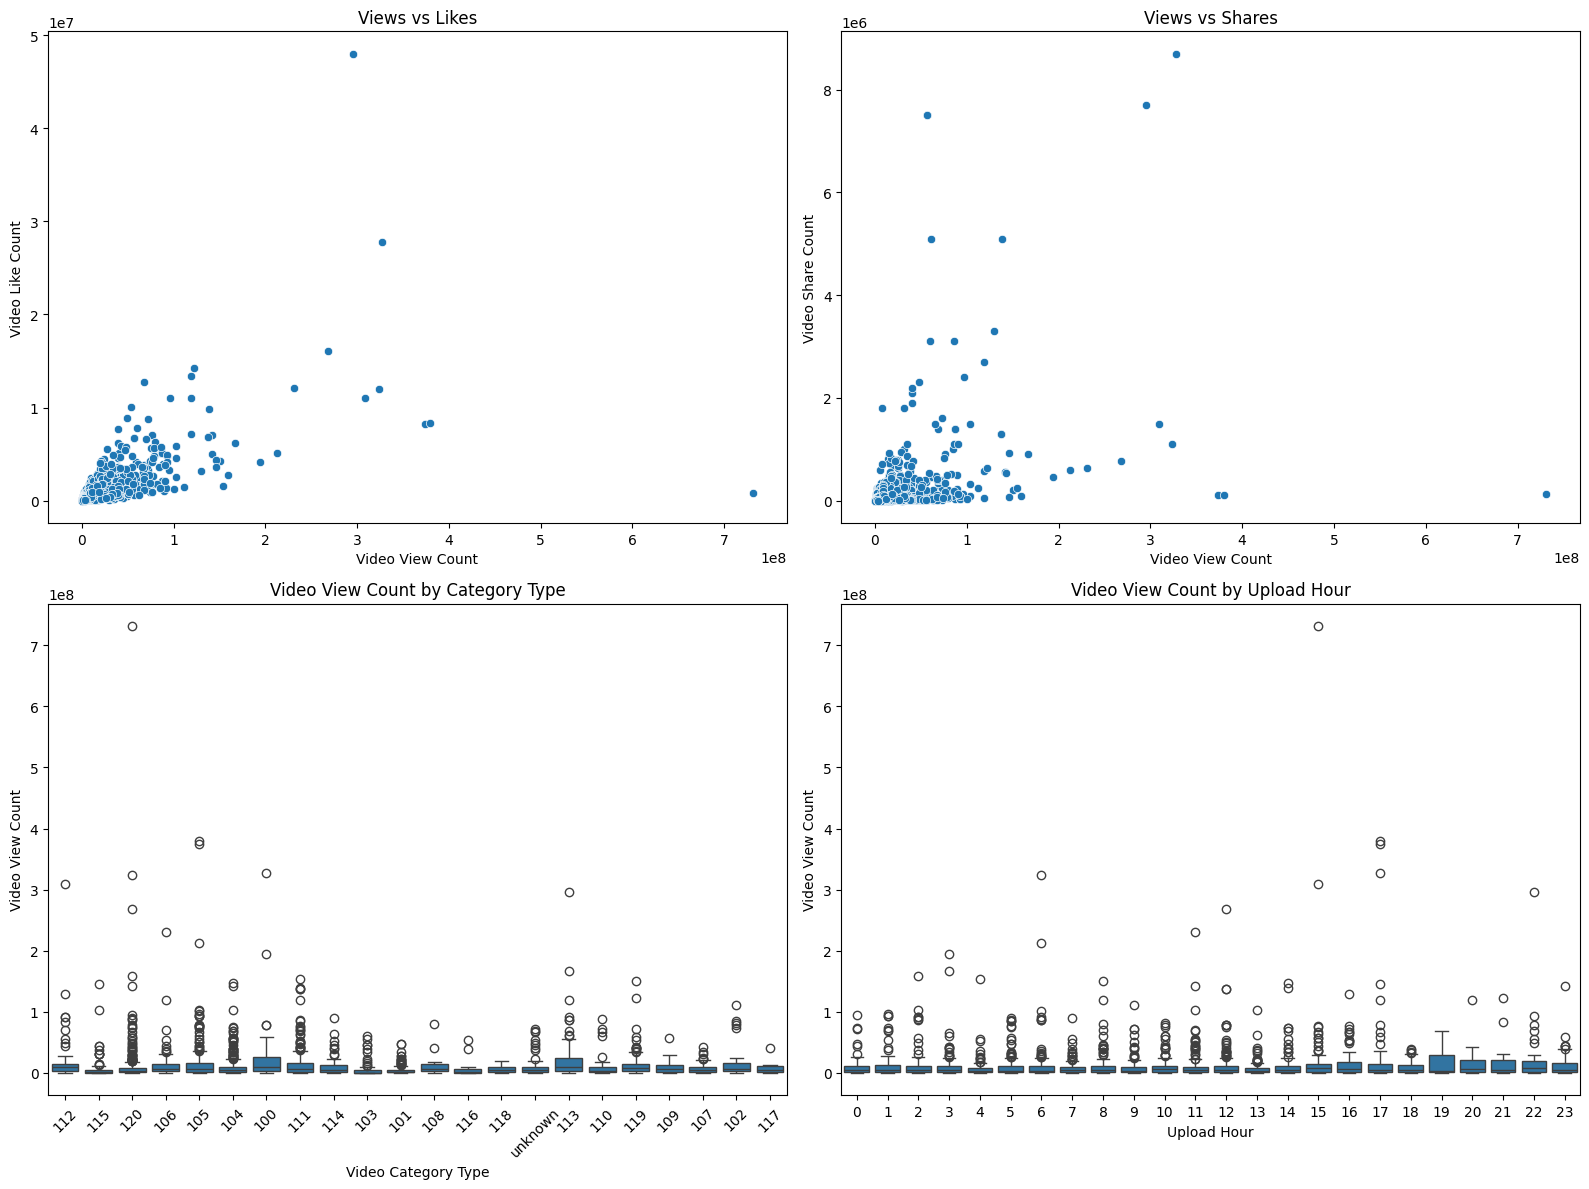

In [35]:
# Tambahkan kolom kategori waktu dan tipe video
extended_df = df[[
    "Video View Count",
    "Video Like Count",
    "Video Comment Count",
    "Video Share Count",
    "Video Category Type",
    "Upload Hour",
    "Upload Day"
]]

# Ubah Upload Day menjadi kategorikal ordinal
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
extended_df['Upload Day'] = pd.Categorical(extended_df['Upload Day'], categories=day_order, ordered=True)

# Visualisasi korelasi antar fitur numerik + boxplot untuk kategori
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Korelasi View vs Like
sns.scatterplot(data=extended_df, x="Video View Count", y="Video Like Count", ax=axes[0, 0])
axes[0, 0].set_title("Views vs Likes")

# Korelasi View vs Share
sns.scatterplot(data=extended_df, x="Video View Count", y="Video Share Count", ax=axes[0, 1])
axes[0, 1].set_title("Views vs Shares")

# Boxplot: Video Category Type vs Views
sns.boxplot(data=extended_df, x="Video Category Type", y="Video View Count", ax=axes[1, 0])
axes[1, 0].set_title("Video View Count by Category Type")
axes[1, 0].tick_params(axis='x', rotation=45)

# Boxplot: Upload Hour vs Views
sns.boxplot(data=extended_df, x="Upload Hour", y="Video View Count", ax=axes[1, 1])
axes[1, 1].set_title("Video View Count by Upload Hour")

plt.tight_layout()
plt.show()


### 1. Views vs Likes (Top-Left)
- Terdapat **korelasi positif kuat** antara jumlah view dan jumlah like.
- Artinya: video dengan banyak views cenderung mendapatkan banyak likes.
- Namun, terdapat **outlier** — beberapa video punya views sangat tinggi tapi like-nya relatif rendah → mungkin video viral tapi kurang disukai.

---

### 2. Views vs Shares (Top-Right)
- Korelasinya lebih **lemah dan menyebar** dibanding view vs like.
- Beberapa video dengan view rendah bisa mendapat banyak share → bisa jadi kontennya sangat menarik untuk disebarluaskan meski tidak viral.
- Sebaliknya, banyak video dengan view tinggi tapi share-nya minim → menunjukkan bahwa share behavior lebih tergantung pada **motivasi personal** pengguna.

---

### 3. Video View Count by Category Type (Bottom-Left)
- **Kategori 112, 115, 104, 106** mendominasi dalam hal potensi viral (banyak outlier dengan view ekstrem).
- Median view di kategori-kategori ini juga terlihat lebih tinggi dibanding kategori lainnya.
- Sebagian besar kategori lainnya memiliki persebaran view yang pendek dan rendah → bisa jadi lebih niche atau kurang menarik bagi massa.
- Insight: pemilihan kategori yang tepat bisa sangat memengaruhi performa video.

---

### 4. Video View Count by Upload Hour (Bottom-Right)
- Terdapat persebaran yang cukup **seragam** di semua jam, tapi jam **16–20** menunjukkan persebaran dan outlier view yang lebih tinggi.
- Jam **subuh (0–5)** cenderung memiliki distribusi view yang rendah.
- Insight: waktu upload tetap penting, terutama jika ditargetkan ke audiens aktif malam hari.

---

## Kesimpulan
- **Views dan Likes** berkorelasi kuat, tapi **Shares dan Comments** lebih kompleks dan tidak selalu berbanding lurus.
- **Kategori dan Jam Upload** memiliki pengaruh terhadap potensi viralitas, namun perlu dikombinasikan dengan elemen konten dan engagement rate.
- Outlier muncul di hampir semua kategori dan jam → clustering atau segmentasi berdasarkan engagement bisa mengungkap pola-pola tersembunyi dari audiens aktif.



<Axes: xlabel='Upload Hour', ylabel='Upload Day'>

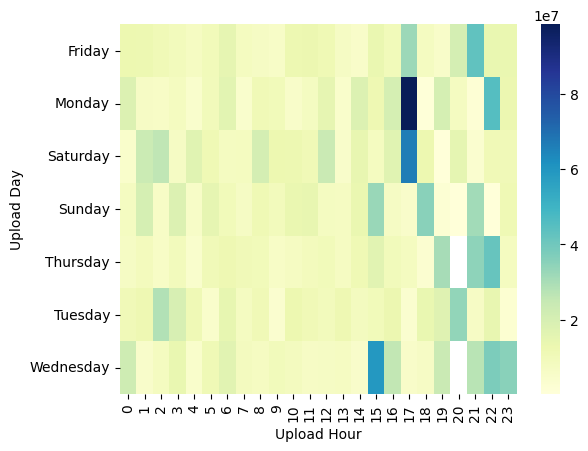

In [36]:
# Heatmap visualisasi rata-rata views berdasarkan hari dan jam upload
pivot = df.pivot_table(index='Upload Day', columns='Upload Hour', values='Video View Count', aggfunc='mean')
sns.heatmap(pivot, cmap='YlGnBu')

#### 1. **Waktu Terbaik untuk Upload (Prime Time)**
- **Senin jam 17.00–18.00** menunjukkan puncak view tertinggi secara ekstrem — bisa jadi momen audiens kembali aktif setelah aktivitas siang.
- Jam **19.00–21.00** secara umum menunjukkan view yang tinggi di hampir semua hari, terutama **Senin, Kamis, Jumat, dan Minggu**.

#### 2. **Hari Terbaik untuk Upload**
- **Senin dan Kamis** secara konsisten punya slot waktu dengan view tinggi.
- **Rabu dan Minggu** juga menunjukkan performa bagus di malam hari.
- Hari **Selasa dan Sabtu** tampaknya lebih datar dan kurang optimal untuk view tinggi.

#### 3. **Jam yang Kurang Efektif**
- Upload antara jam **00.00–09.00** hampir di semua hari menghasilkan **view yang rendah**.
- Bisa diasumsikan audiens belum aktif atau belum membuka TikTok pada waktu-waktu tersebut.

---

### Rekomendasi Strategi Konten

| Hari       | Jam Upload yang Disarankan |
|------------|----------------------------|
| Senin      | 17:00 – 21:00              |
| Kamis      | 18:00 – 22:00              |
| Minggu     | 18:00 – 21:00              |
| Rabu       | 15:00 – 20:00              |

- Hindari upload pada jam 00.00 – 09.00, terutama di hari kerja.
- Jika menyasar audiens masif, fokuskan konten unggulan di Senin sore/malam.

---



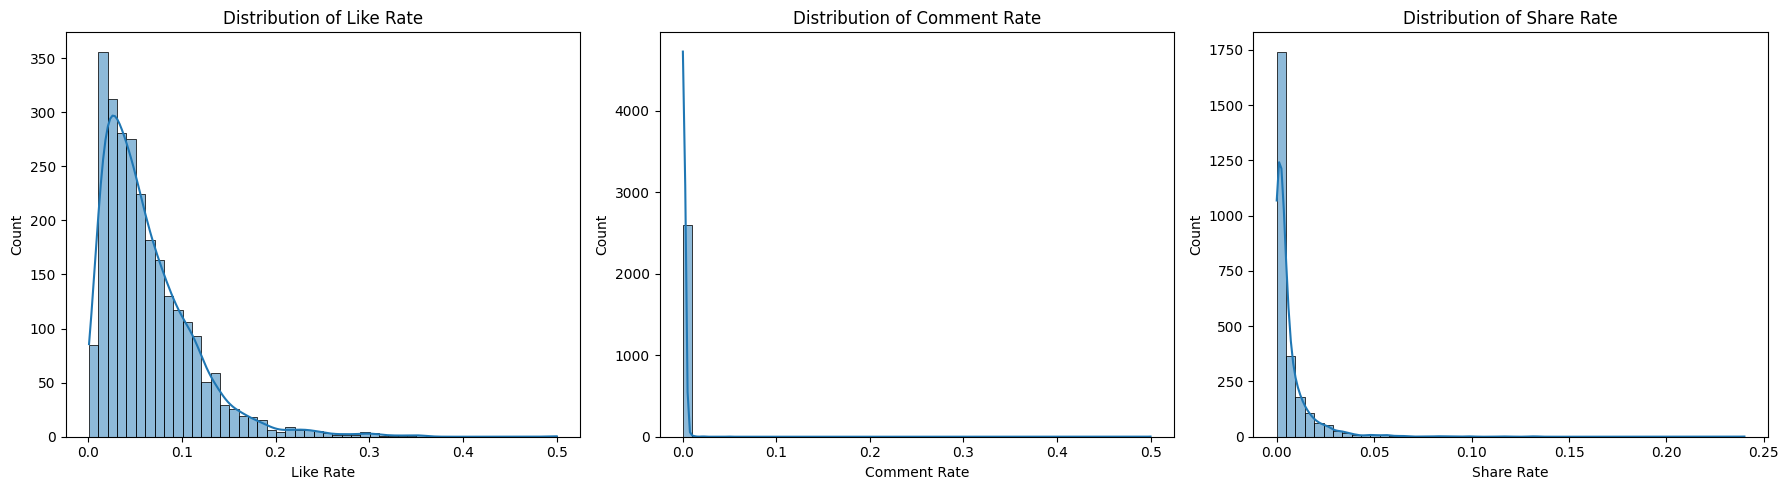

In [37]:
# Tambahkan engagement rate (rasio)
df['like_rate'] = df['Video Like Count'] / df['Video View Count']
df['comment_rate'] = df['Video Comment Count'] / df['Video View Count']
df['share_rate'] = df['Video Share Count'] / df['Video View Count']

# Ganti inf dan NaN hasil pembagian
df[['like_rate', 'comment_rate', 'share_rate']] = df[['like_rate', 'comment_rate', 'share_rate']].replace([np.inf, -np.inf], np.nan).fillna(0)

# Visualisasi distribusi rasio engagement
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['like_rate'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Like Rate")
axes[0].set_xlabel("Like Rate")

sns.histplot(df['comment_rate'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Comment Rate")
axes[1].set_xlabel("Comment Rate")

sns.histplot(df['share_rate'], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of Share Rate")
axes[2].set_xlabel("Share Rate")

plt.tight_layout()
plt.show()


### 1. Like Rate
- Distribusi **right-skewed (condong ke kanan)** dengan puncak pada nilai rendah (sekitar 0.03–0.05).
- Sebagian besar video mendapatkan **like rate di bawah 10%**, artinya hanya sebagian kecil viewer yang benar-benar menekan tombol like.
- Terdapat outlier yang mencapai hingga **0.5 (50%)**, yang bisa jadi sinyal kuat video dengan **audiens loyal atau sangat disukai**.

---

### 2. Comment Rate
- Sangat **skewed ke kanan dan tajam**, dengan sebagian besar video hanya mendapat **< 1% dari viewer yang berkomentar**.
- Komentar adalah bentuk engagement yang lebih aktif → **menunjukkan bahwa hanya sedikit audiens yang benar-benar ingin berinteraksi dalam bentuk tulisan.**
- Namun, video dengan comment rate tinggi bisa dianggap **memicu diskusi atau reaksi**.

---

### 3. Share Rate
- Juga **sangat skewed** -> sebagian besar video hanya dishare oleh <1% dari penontonnya.
- Tapi distribusinya lebih “rapat” daripada comment rate -> menunjukkan bahwa share lebih umum dilakukan dibanding komentar.
- Share rate tinggi bisa jadi **indikator kuat viralitas**, karena pengguna merasa konten layak disebarluaskan.

---

### Insight

| Rasio         | Interpretasi Potensial                                              |
|---------------|----------------------------------------------------------------------|
| Like Rate     | Indikator approval -> seberapa besar video disukai                   |
| Comment Rate  | Indikator keterlibatan mendalam -> diskusi, opini, reaksi emosional  |
| Share Rate    | Indikator viralitas -> keinginan untuk menyebarkan konten            |

- Rasio-rasio ini **lebih representatif daripada jumlah absolut**, karena mengukur **kualitas interaksi relatif terhadap view**.
- Sangat cocok digunakan dalam **model clustering**, karena mencerminkan **tipe audiens** (pasif, suka, aktif, viral).

# Feature Engineering

In [38]:
# Download stopwords
nltk.download('stopwords')
stop_words_en = set(stopwords.words('english'))
stop_words_id = set(stopwords.words('indonesian'))
stop_words_combined = list(stop_words_en.union(stop_words_id))  # <--- penting!

# Function untuk membersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove urls
    text = re.sub(r'\d+', '', text)              # remove numbers
    text = re.sub(r'[^\w\s]', '', text)          # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces
    return text

# Apply cleaning
df["clean_description"] = df["Video Description"].apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words=stop_words_combined, max_features=500, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df["clean_description"])

# Cek bentuk dan contoh fitur TF-IDF
tfidf_shape = tfidf_matrix.shape
tfidf_features = vectorizer.get_feature_names_out()[:10]
print(tfidf_shape)
print(tfidf_features)


(2600, 500)
['abu' 'abu nawas' 'acara' 'adayinmylife' 'address' 'adik' 'ai' 'aja' 'al'
 'alhamdulillah']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Pilih fitur numerik yang akan digabung
numeric_cols = ['Upload Hour', 'Video Duration',
                'Video View Count', 'Video Like Count',
                'Video Comment Count', 'Video Share Count']

# Standardisasi
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols])

# Gabungkan TF-IDF + numerik
X_clustering = hstack([tfidf_matrix, scaled_numeric])

# Output bentuk akhir
print("TF-IDF shape:", tfidf_matrix.shape)
print("Numerik shape:", scaled_numeric.shape)
print("Final shape:", X_clustering.shape)


TF-IDF shape: (2600, 500)
Numerik shape: (2600, 6)
Final shape: (2600, 506)


In [40]:
# Ubah Author Verified ke integer
df['Author Verified'] = df['Author Verified'].astype(int)

# One-hot encode Upload Day
onehot_day = OneHotEncoder(sparse_output=False)  # ganti ini!
encoded_day = onehot_day.fit_transform(df[['Upload Day']])

# Label encode Video Category Type
labelenc_cat = LabelEncoder()
encoded_cat = labelenc_cat.fit_transform(df['Video Category Type']).reshape(-1, 1)

# Gabungkan semua fitur
X_clustering_final = hstack([
    tfidf_matrix, # text
    scaled_numeric, # numerik
    csr_matrix(df[['Author Verified']]), # binary
    csr_matrix(encoded_day), # day
    csr_matrix(encoded_cat)  # encoded category
])

# Cek bentuk akhir
print("Final shape with kategori:", X_clustering_final.shape)

Final shape with kategori: (2600, 515)


# Modelling

## KMeans


In [41]:
# Test beberapa cluster
interia = []
silhouette_scores = []
K_range = range(2, 11)

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(X_clustering_final)
    interia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering_final, kmeans.labels_))

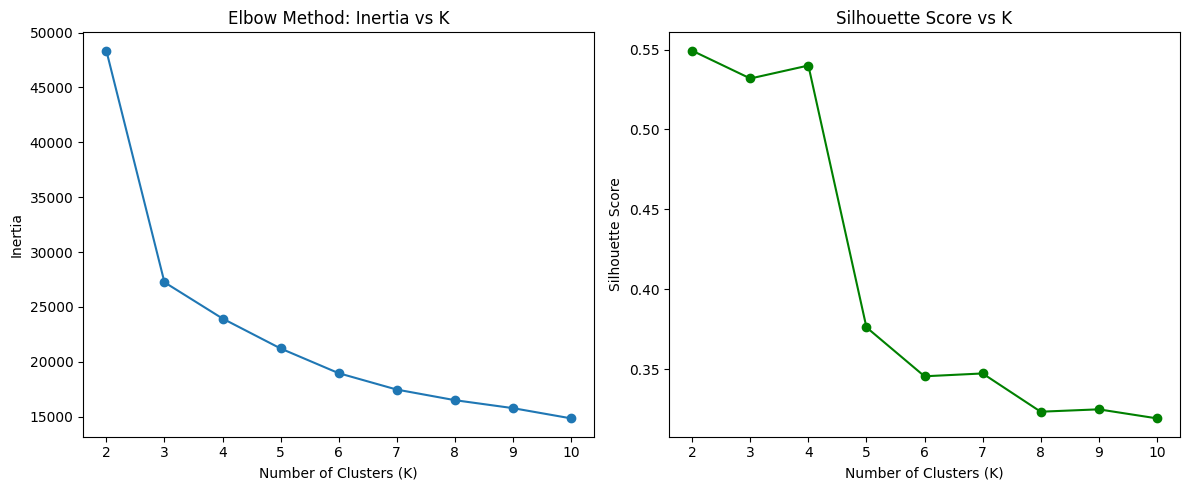

In [42]:
# Visualisasi Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, interia, marker='o')
plt.title("Elbow Method: Inertia vs K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")

# Visualisasi Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


In [43]:
# Final clustering dengan K terbaik
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)

In [44]:
df['Cluster'] = kmeans_final.fit_predict(X_clustering_final)

In [45]:
# Cek distribusi cluster
print("Distribusi Jumlah Video per Cluster:")
print(df['Cluster'].value_counts())

Distribusi Jumlah Video per Cluster:
Cluster
0    1164
2     725
1     688
3      23
Name: count, dtype: int64


In [46]:
# Print top 5 kategori per cluster
print("Top 5 Kategori per Cluster:")
for i in range(4):
    top_cats = df[df['Cluster'] == i]['Video Category Type'].value_counts().head(5)
    print(f"Cluster {i}:\n{top_cats}")
    print()

Top 5 Kategori per Cluster:
Cluster 0:
Video Category Type
104    358
101    216
105    210
107    120
103     92
Name: count, dtype: int64

Cluster 1:
Video Category Type
120        389
unknown    165
119        109
118         14
117         10
Name: count, dtype: int64

Cluster 2:
Video Category Type
111    304
115    104
114     79
112     79
113     72
Name: count, dtype: int64

Cluster 3:
Video Category Type
113    5
105    4
112    3
120    3
111    3
Name: count, dtype: int64



In [47]:
# Video dgn view terbanyak per cluster
for i in range(4):
    top_vid = df[df['Cluster'] == i].sort_values(by='Video View Count', ascending=False).iloc[0]
    print(f"\nCluster {i} - View tertinggi:")
    print(f"Username: {top_vid['Author Username']}")
    print(f"Views: {int(top_vid['Video View Count'])}")
    print(f"Category: {top_vid['Video Category Type']}")
    print(f"Description: {top_vid['Video Description']}")
    print(f"URL: {top_vid['Video Page URL']}")


Cluster 0 - View tertinggi:
Username: tom891907te
Views: 212600000
Category: 105
Description: satisfying ice slicing - pure visual zen! #iceasmr #asmrsounds #satisfyingsounds #icesounds #summe
URL: https://www.tiktok.com/@tom891907te/video/7517178353871342903

Cluster 1 - View tertinggi:
Username: artistwhisper
Views: 159100000
Category: 120
Description: how to draw face with pencil   . . . #draw #howtodraw #sketch #drawingtutorial #artistoftiktok #drawingprocess
URL: https://www.tiktok.com/@artistwhisper/video/7497442098170334486

Cluster 2 - View tertinggi:
Username: _onfood
Views: 154200000
Category: 111
Description: a must-try in malacca! only $2 for sugar-free watermelon juice! #streetfood  #malaysia  #malacca  #watermelon
URL: https://www.tiktok.com/@_onfood/video/7494869093930126610

Cluster 3 - View tertinggi:
Username: tiktokliveid
Views: 731500000
Category: 120
Description: dulu cuma jadi penonton. sekarang? @mamila udah jadi kreator live yang punya komunitas sendiri!  perja

In [48]:
# PCA → reduksi ke 2D
pca = PCA(n_components=2, random_state=42)

In [49]:
X_pca = pca.fit_transform(X_clustering_final.toarray())

In [50]:
# TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

In [51]:
X_tsne = tsne.fit_transform(X_clustering_final.toarray())

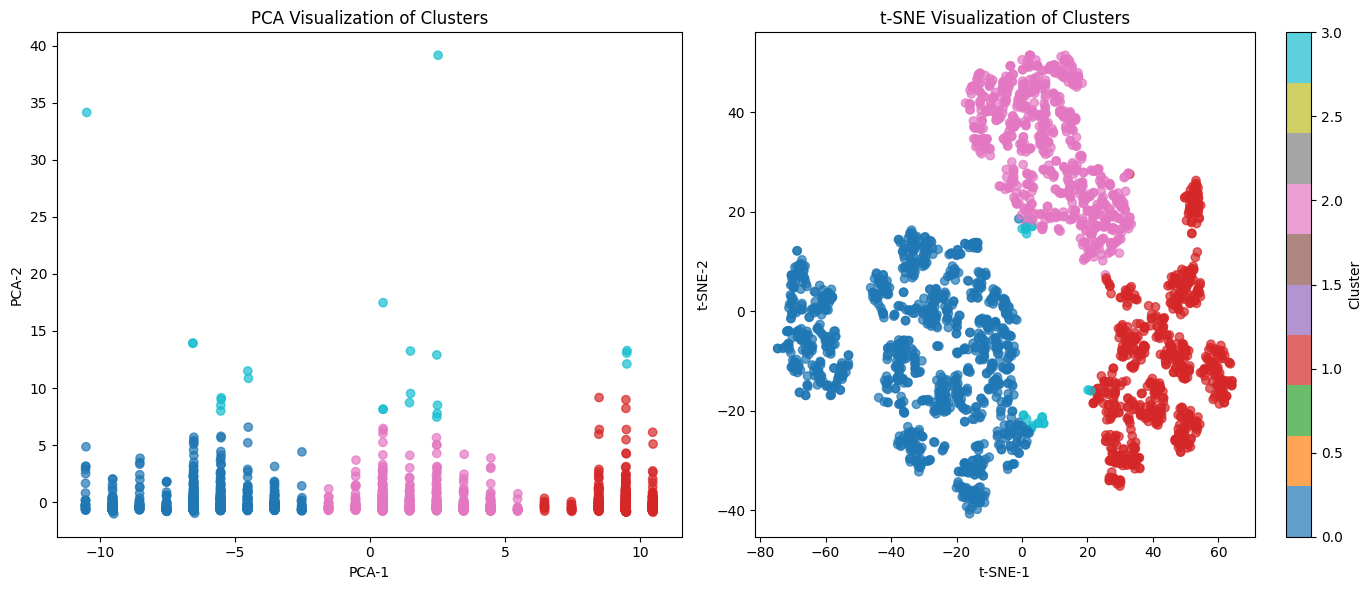

In [52]:
# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Plot
scatter_pca = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='tab10', alpha=0.7)
axes[0].set_title("PCA Visualization of Clusters")
axes[0].set_xlabel("PCA-1")
axes[0].set_ylabel("PCA-2")

# TSNE Plot
scatter_tsne = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='tab10', alpha=0.7)
axes[1].set_title("t-SNE Visualization of Clusters")
axes[1].set_xlabel("t-SNE-1")
axes[1].set_ylabel("t-SNE-2")

plt.colorbar(scatter_tsne, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

## HDBSCAN

In [53]:
X_dense = X_clustering_final.toarray()

# Define HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)
labels_hdb = clusterer.fit_predict(X_dense)


In [54]:
# Simpan hasil ke dataframe
df['HDBSCAN_Cluster'] = labels_hdb

# Lihat distribusi hasil
print(df['HDBSCAN_Cluster'].value_counts())

# Hitung cluster vs noise
n_noise = (labels_hdb == -1).sum()
n_cluster = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
print(f"\nJumlah cluster valid: {n_cluster}")
print(f"Jumlah noise/outlier: {n_noise}")

HDBSCAN_Cluster
-1    902
 2    765
 0    536
 1    397
Name: count, dtype: int64

Jumlah cluster valid: 3
Jumlah noise/outlier: 902


In [55]:
# Reduksi dimensi
X_dense = X_clustering_final.toarray()

In [56]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_pca_hdb = pca.fit_transform(X_dense)

In [57]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne_hdb = tsne.fit_transform(X_dense)

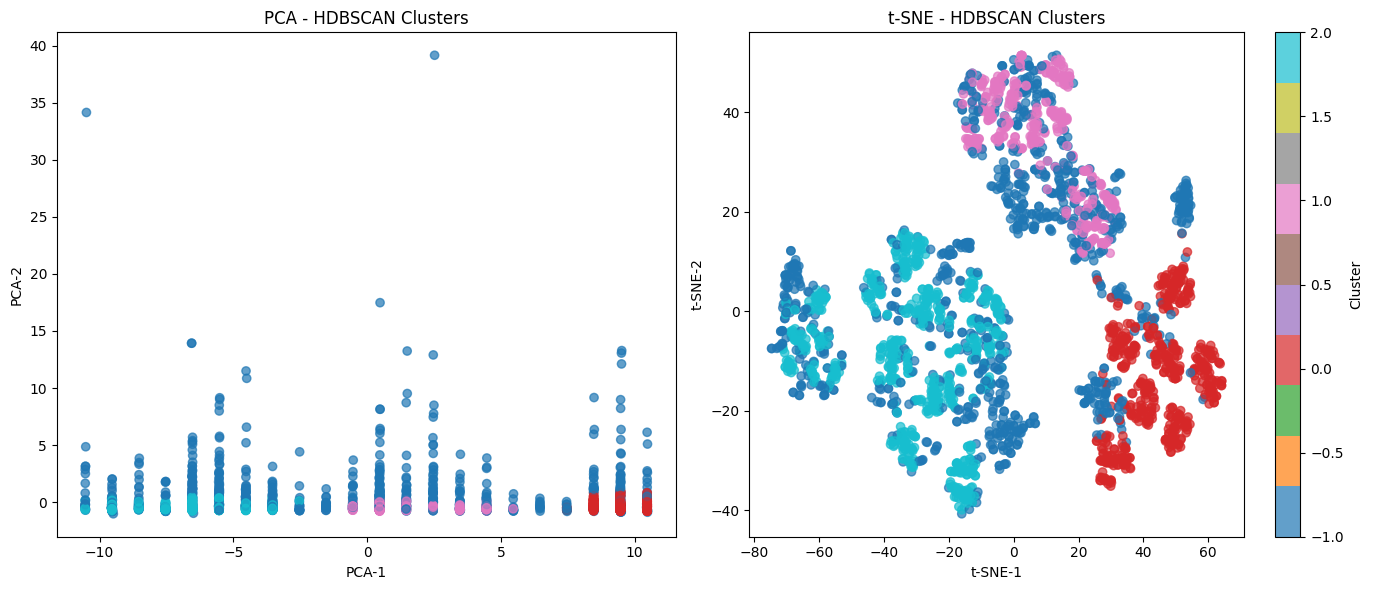

In [58]:
# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(X_pca_hdb[:, 0], X_pca_hdb[:, 1], c=df['HDBSCAN_Cluster'], cmap='tab10', alpha=0.7)
axes[0].set_title("PCA - HDBSCAN Clusters")
axes[0].set_xlabel("PCA-1")
axes[0].set_ylabel("PCA-2")

scatter2 = axes[1].scatter(X_tsne_hdb[:, 0], X_tsne_hdb[:, 1], c=df['HDBSCAN_Cluster'], cmap='tab10', alpha=0.7)
axes[1].set_title("t-SNE - HDBSCAN Clusters")
axes[1].set_xlabel("t-SNE-1")
axes[1].set_ylabel("t-SNE-2")

plt.colorbar(scatter2, ax=axes[1], label="Cluster")
plt.tight_layout()
plt.show()

In [59]:
print("Top 5 Kategori Tiap HDBSCAN Cluster:")
for i in sorted(df['HDBSCAN_Cluster'].unique()):
    if i == -1:
        label = "Noise"
    else:
        label = f"Cluster {i}"
    top_cats = df[df['HDBSCAN_Cluster'] == i]['Video Category Type'].value_counts().head(5)
    print(f"\n{label}:\n{top_cats}")


Top 5 Kategori Tiap HDBSCAN Cluster:

Noise:
Video Category Type
111    95
120    82
104    78
101    76
105    65
Name: count, dtype: int64

Cluster 0:
Video Category Type
120        310
unknown    143
119         79
118          4
Name: count, dtype: int64

Cluster 1:
Video Category Type
111    212
115     66
114     35
110     33
112     30
Name: count, dtype: int64

Cluster 2:
Video Category Type
104    282
105    149
101    140
107     75
103     57
Name: count, dtype: int64


In [60]:
print("\nVideo dengan View Tertinggi per HDBSCAN Cluster:")
for i in sorted(df['HDBSCAN_Cluster'].unique()):
    subset = df[df['HDBSCAN_Cluster'] == i]
    if len(subset) == 0: continue
    top_vid = subset.sort_values(by='Video View Count', ascending=False).iloc[0]
    label = f"Cluster {i}" if i != -1 else "Noise"
    print(f"\n{label}:")
    print(f"Username: {top_vid['Author Username']}")
    print(f"Views: {int(top_vid['Video View Count'])}")
    print(f"Category: {top_vid['Video Category Type']}")
    print(f"Description: {top_vid['Video Description']}")
    print(f"URL: {top_vid['Video Page URL']}")



Video dengan View Tertinggi per HDBSCAN Cluster:

Noise:
Username: tiktokliveid
Views: 731500000
Category: 120
Description: dulu cuma jadi penonton. sekarang? @mamila udah jadi kreator live yang punya komunitas sendiri!  perjalanan mamila buktiin kalau semua orang punya kesempatan untuk mulai, asal berani coba! kalau mamila bisa, kamu juga pasti bisa. yuk gabung dan rayain serunya #communityfest2025 bareng kreator dan komunitas favoritmu!
URL: https://www.tiktok.com/@tiktokliveid/video/7514719650207239432

Cluster 0:
Username: duniapunyacerita_
Views: 60600000
Category: 120
Description: starting  ending
URL: https://www.tiktok.com/@duniapunyacerita_/video/7498652013446597894

Cluster 1:
Username: yumi.matchelin
Views: 35100000
Category: 111
Description: missing_description
URL: https://www.tiktok.com/@yumi.matchelin/video/7511608884176489736

Cluster 2:
Username: papanaufalf
Views: 33100000
Category: 105
Description: tips mengganti cat rumah dengan cepat menggunakan semprotan angin #f

## DBSCAN

In [61]:
valid_labels = labels_hdb[labels_hdb != -1]
n_clusters = len(set(valid_labels))

print(n_cluster)

3


In [62]:
for eps_val in [1.5, 2.0, 2.5, 3.0]:
    db = DBSCAN(eps=eps_val, min_samples=10, n_jobs=-1)
    labels = db.fit_predict(X_dense)
    n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"EPS={eps_val} → Cluster: {n_cluster}, Noise: {n_noise}")


EPS=1.5 → Cluster: 3, Noise: 986
EPS=2.0 → Cluster: 2, Noise: 297
EPS=2.5 → Cluster: 1, Noise: 125
EPS=3.0 → Cluster: 1, Noise: 74


In [63]:
# Build ulang model
db = DBSCAN(eps=1.5, min_samples=10, n_jobs=-1)
labels = db.fit_predict(X_dense)

# Masukkan ke df
df['DBSCAN_Tuned'] = labels

# Hitung silhouette
valid = labels != -1
if len(set(labels[valid])) >= 2:
    score = silhouette_score(X_dense[valid], labels[valid])
    print(f"\nSilhouette Score (DBSCAN eps=1.5, tanpa noise): {score:.4f}")
else:
    print("Masih belum cukup cluster valid untuk silhouette.")



Silhouette Score (DBSCAN eps=1.5, tanpa noise): 0.6226


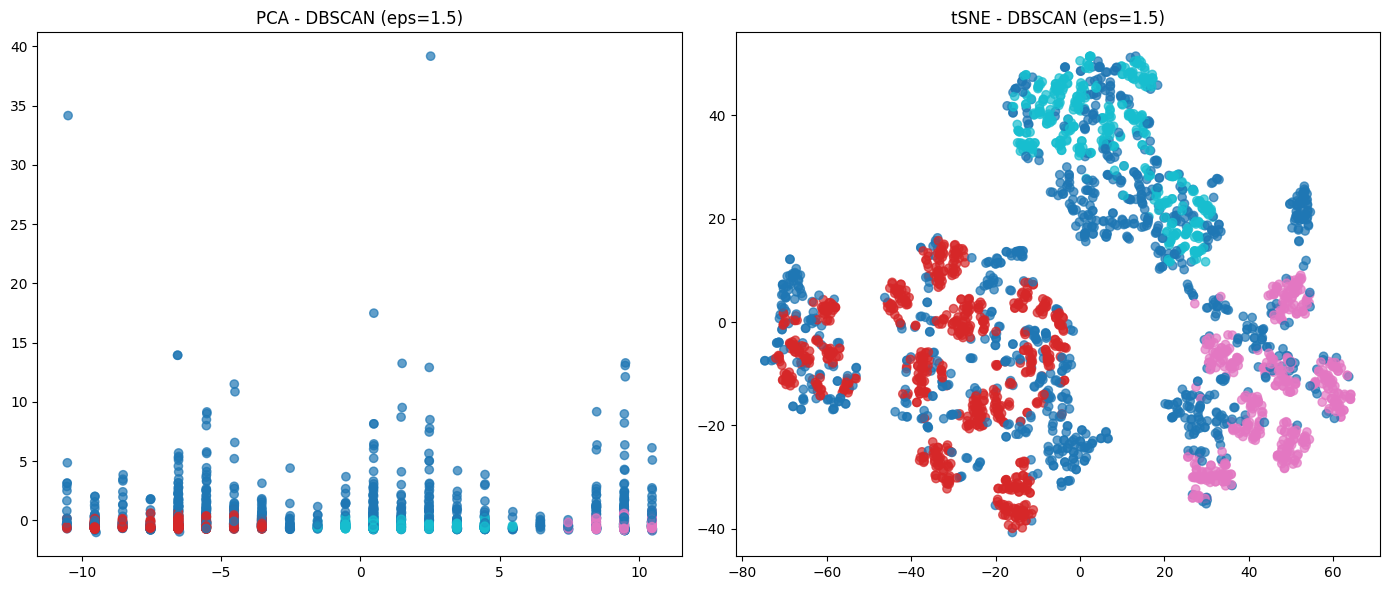

In [64]:
# Visualisasi
X_dbscan = X_dense
labels_db = df['DBSCAN_Tuned']

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dbscan)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_dbscan)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_db, cmap='tab10', alpha=0.7)
axes[0].set_title("PCA - DBSCAN (eps=1.5)")

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_db, cmap='tab10', alpha=0.7)
axes[1].set_title("tSNE - DBSCAN (eps=1.5)")

plt.tight_layout()
plt.show()


In [65]:
print("Top 5 Kategori Tiap DBSCAN Cluster (eps=1.5):")
for label in sorted(df['DBSCAN_Tuned'].unique()):
    cluster_name = f"Noise" if label == -1 else f"Cluster {label}"
    top_cats = df[df['DBSCAN_Tuned'] == label]['Video Category Type'].value_counts().head(5)
    print(f"\n{cluster_name}:\n{top_cats}")


Top 5 Kategori Tiap DBSCAN Cluster (eps=1.5):

Noise:
Video Category Type
120    117
111     98
101     76
104     74
105     67
Name: count, dtype: int64

Cluster 0:
Video Category Type
104    286
105    147
101    140
107     65
103     51
Name: count, dtype: int64

Cluster 1:
Video Category Type
120        275
unknown    116
119         62
118          2
Name: count, dtype: int64

Cluster 2:
Video Category Type
111    209
115     69
110     39
112     35
114     29
Name: count, dtype: int64


In [66]:
for label in sorted(df['DBSCAN_Tuned'].unique()):
    subset = df[df['DBSCAN_Tuned'] == label]
    if len(subset) == 0: continue
    top_vid = subset.sort_values(by='Video View Count', ascending=False).iloc[0]
    cluster_name = f"Noise" if label == -1 else f"Cluster {label}"
    print(f"\n{cluster_name} - Top View:")
    print(f"Username: {top_vid['Author Username']}")
    print(f"Views: {int(top_vid['Video View Count'])}")
    print(f"Category: {top_vid['Video Category Type']}")
    print(f"Description: {top_vid['Video Description']}")
    print(f"URL: {top_vid['Video Page URL']}")



Noise - Top View:
Username: tiktokliveid
Views: 731500000
Category: 120
Description: dulu cuma jadi penonton. sekarang? @mamila udah jadi kreator live yang punya komunitas sendiri!  perjalanan mamila buktiin kalau semua orang punya kesempatan untuk mulai, asal berani coba! kalau mamila bisa, kamu juga pasti bisa. yuk gabung dan rayain serunya #communityfest2025 bareng kreator dan komunitas favoritmu!
URL: https://www.tiktok.com/@tiktokliveid/video/7514719650207239432

Cluster 0 - Top View:
Username: shabrinaadfii
Views: 34500000
Category: 103
Description: missing_description
URL: https://www.tiktok.com/@shabrinaadfii/video/7512332954257902904

Cluster 1 - Top View:
Username: babale043
Views: 44900000
Category: unknown
Description: missing_description
URL: https://www.tiktok.com/@babale043/video/7519486226680778006

Cluster 2 - Top View:
Username: yumi.matchelin
Views: 35100000
Category: 111
Description: missing_description
URL: https://www.tiktok.com/@yumi.matchelin/video/751160888417

| Kriteria           | KMeans             | HDBSCAN             | DBSCAN (eps=1.5)         |
| ------------------ | ------------------ | ------------------- | ------------------------ |
| Cluster 0          | Satisfying / tips  | Creative tutorials  | Creative / storytelling  |
| Cluster 1          | Creative tutorials | F\&B / lifestyle    | F\&B / lifestyle         |
| Cluster 2          | F\&B / streetfood  | Satisfying          | Satisfying / visual tips |
| Noise (-1)         | -        | Brand, TikTok event | Brand, TikTok event      |
| View tertinggi     | 212M (satisfying)  | 731M (event)        | 731M (event)             |
| Outlier separation | ❌ Tercampur        | ✅ Sangat jelas      | ✅ Sangat jelas           |
